In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *
from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [3]:
xr.set_options(display_style='text') 

# Functions, data

In [4]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [5]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [6]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')

In [7]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [8]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [9]:
def interp_eta_to_pressure(ds,var,staggered=1,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        i=0
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
            rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])

In [10]:
import wrf
from netCDF4 import Dataset
def interp_pressure(var):
    """var must be destaggered"""
    plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout_d01_1970-02-20_06_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

In [11]:
from scipy.interpolate import interp1d
def interp_pressure2(ds,var,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4][::-1]/100
    rep=np.zeros((len(var.Time),len(plevs),len(var.south_north),len(var.west_east)))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[:,::-1]
    for k in range(len(var.west_east)):
        rep[:,:,:,k]=interp1d(PB_rev[:,k], var_rev[:,:,:,k], kind='linear', axis=1,fill_value='extrapolate', assume_sorted=True)(plevs*100)

    return xr.DataArray(rep[:,::-1],coords={'Time':var.Time,'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['Time','pressure','south_north','west_east'])

## Extra data & functions

In [94]:
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

rhomean = rhomean.where(rhomean >0.)  
wmean   = wmean.where(wmean > -10)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[1:-4]
wmean_p =     change_coords_pl(hrchannel_p,wmean)[1:-4]
zmean_p =     change_coords_pl(hrchannel_p,zmean)[1:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[1:-4]

In [55]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
umean = umean.where(umean >-30.)  
umean_p = change_coords_pl(hrchannel_p,umean)[1:-4]

In [12]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
rhomean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')
tmean_s   = change_coords_eta(hrchannel,tmean_s  )
rhomean_s = change_coords_eta(hrchannel,rhomean_s)    

    

In [8]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [9]:
lmqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean   = lmqmean.where(lmqmean >0.)  
lmtmean   = lmtmean.where(lmtmean >100.)
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)
lmqmean_p = change_coords_pl(lmchannel_p,lmqmean)

In [10]:
lmtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
lmtmean_s   = change_coords_eta(hrchannel,lmtmean_s  ) 
lmqmean_s   = change_coords_eta(hrchannel,lmqmean_s  )

In [11]:
aqtmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.T_PL.days50-100.nc')
aqqmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.Q_PL.days50-100.nc')
aqqmean   = aqqmean.where(aqqmean >0.)  
aqtmean   = aqtmean.where(aqtmean >100.)
aqtmean_p = change_coords_pl(lmchannel_p,aqtmean)
aqqmean_p = change_coords_pl(lmchannel_p,aqqmean)

In [12]:
aqtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.TEMP.days50-100.nc')
aqqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.QVAPOR.days50-100.nc')
aqtmean_s   = change_coords_eta(hrchannel,aqtmean_s  ) 
aqqmean_s   = change_coords_eta(hrchannel,aqqmean_s  )

In [8]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        #skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

# Figure 1 - TRMM climatology & cross-section

In [3]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import gaussian_filter, convolve
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_plot= pr_trmm_mean.sel(latitude=slice(-30,30))
pr_trmm_plot.coords['longitude'] = (pr_trmm_plot.coords['longitude'] + 180) % 360 -180
pr_trmm_plot = pr_trmm_plot.sortby(pr_trmm_plot.longitude)
pr_trmm_plot_allm=pr_trmm_plot
pr_trmm_plot=pr_trmm_plot.mean('month')
pr_trmm_plot_jja=pr_trmm_plot_allm.sel(month=[6,7,8]).mean('month')
pr_trmm_plot_ond=pr_trmm_plot_allm.sel(month=[10,11,12]).mean('month')

In [5]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665
orog_plot = orog.reindex(latitude=list(reversed(orog.latitude))).sel(latitude=slice(-30,30))
orog_plot.coords['longitude'] = (orog_plot.coords['longitude'] + 180) % 360 -180
orog_plot = orog_plot.sortby(orog_plot.longitude)
orog_plot_smooth=xr.apply_ufunc(gaussian_filter,orog_plot  ,kwargs={"sigma":1.5})

In [14]:
era5100u= e5_climatology("*_100u",years=range(1998,2014))
era5100v= e5_climatology("*_100v",years=range(1998,2014))

5.905200481414795
6.431794881820679


In [15]:
u100plot=era5100u.sel(latitude=slice(30,-30))
v100plot=era5100v.sel(latitude=slice(30,-30))

u100plot.coords['longitude'] = (u100plot.coords['longitude'] + 180) % 360 -180
u100plot = u100plot.sortby(u100plot.longitude)
v100plot.coords['longitude'] = (v100plot.coords['longitude'] + 180) % 360 -180
v100plot = v100plot.sortby(v100plot.longitude)


In [16]:
u100plot_jja = u100plot.sel(month=[6,7,8]).mean('month')
v100plot_jja = v100plot.sel(month=[6,7,8]).mean('month')

u100plot_ond = u100plot.sel(month=[10,11,12]).mean('month')
v100plot_ond = v100plot.sel(month=[10,11,12]).mean('month')

In [17]:
def cross_section(lon1,lon2,lat,ax):
    ax2=ax.twinx()
    pr_trmm_plot_jja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='JJA precipitation',linewidth=3)#
    pr_trmm_plot_ond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='OND precipitation',linewidth=3)#
    orog_plot.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation',linewidth=3)#
    ax.set_xlabel('')
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_ylabel('Z (m)')
    ax2.set_ylabel('precipitation (mm/day)')
    ax.set_title('Cross-section at %i°N'%lat,fontsize=20)
    ax.set_title('')
    ax2.set_title('')
    ax.set_xlim((lon1,lon2))
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    return ax2


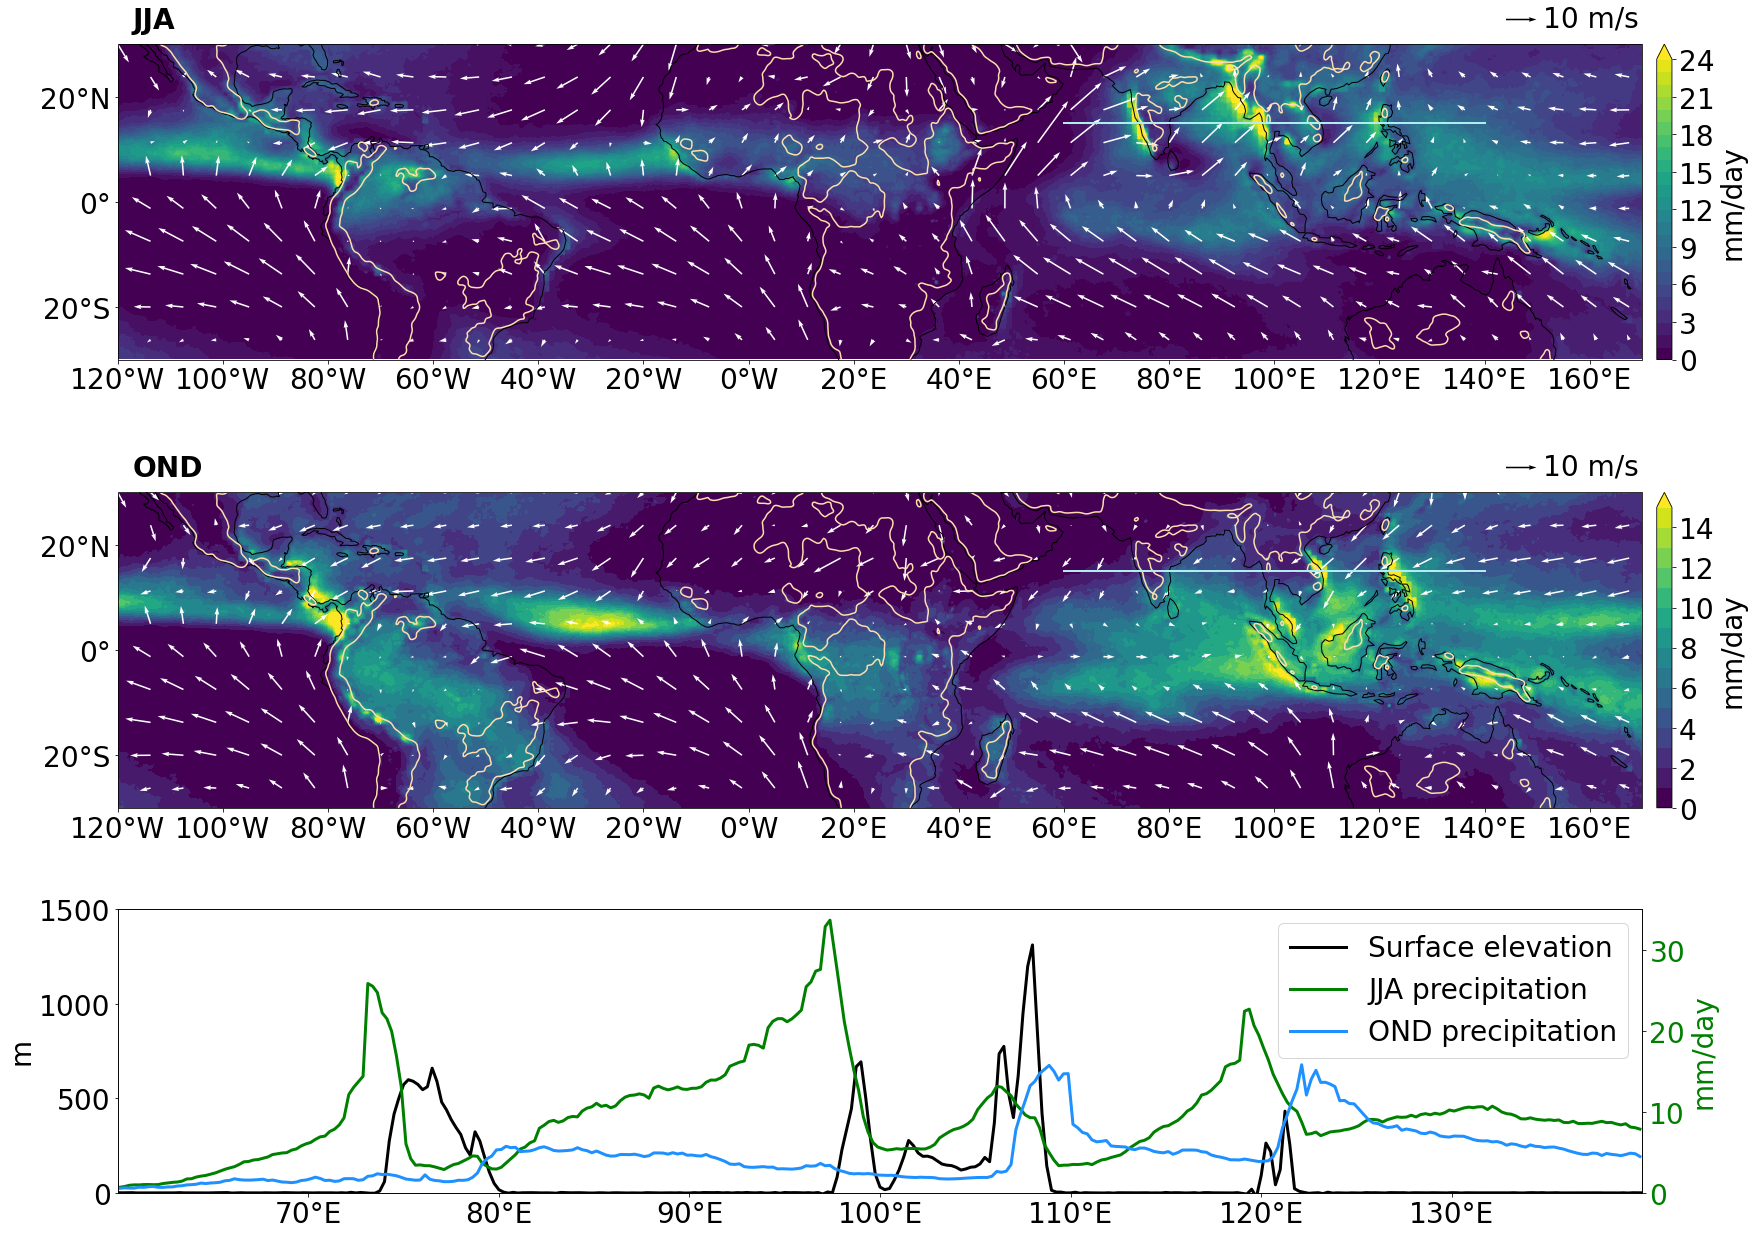

In [18]:
matplotlib.rcParams.update({'font.size': 28})
fig = plt.figure(figsize=(25,18))
spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios= [4,4,3],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax1 = fig.add_subplot(spec[1],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[2])

cf = pr_trmm_plot_jja.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,25.,1.),add_colorbar=False)#,cbar_kwargs={'label':'mm/day'}
cf1=pr_trmm_plot_ond.sel(longitude=slice(-120,170)).plot.contourf(ax=ax1,levels=np.arange(0.,16.,1.),add_colorbar=False)#,cbar_kwargs={'label':'mm/day'}

for a,c,uplot,vplot in (ax,cf,u100plot_jja,v100plot_jja),(ax1,cf1,u100plot_ond,v100plot_ond):
    orog_plot_smooth.sel(longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='navajowhite',linewidths=[1.5])
    
    u=uplot.sel(longitude=slice(-120,170))
    v=vplot.sel(longitude=slice(-120,170))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=25
    m=n
    Q = a.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=500)

    
    a.plot([60,140],[15,15],color='paleturquoise',linewidth=2)
    a.coastlines()
    a.set_ylim(-30,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
    a.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
    pad=.2;size="1%"
    
    divider = make_axes_locatable(a)
    cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    plt.colorbar(c, cax=cax,label='mm/day')

    qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m/s', labelpos='E',
                       coordinates='axes',color='k')
ax.text(0.01, 1.05,'JJA', transform=ax.transAxes,color='k',weight='bold')
ax1.text(0.01, 1.05,'OND', transform=ax1.transAxes,color='k',weight='bold')


ax3=cross_section(60,140,15,ax2)
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1500)
ax3.set_ylim(0,35)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel("mm/day",color='g')
fig.tight_layout()

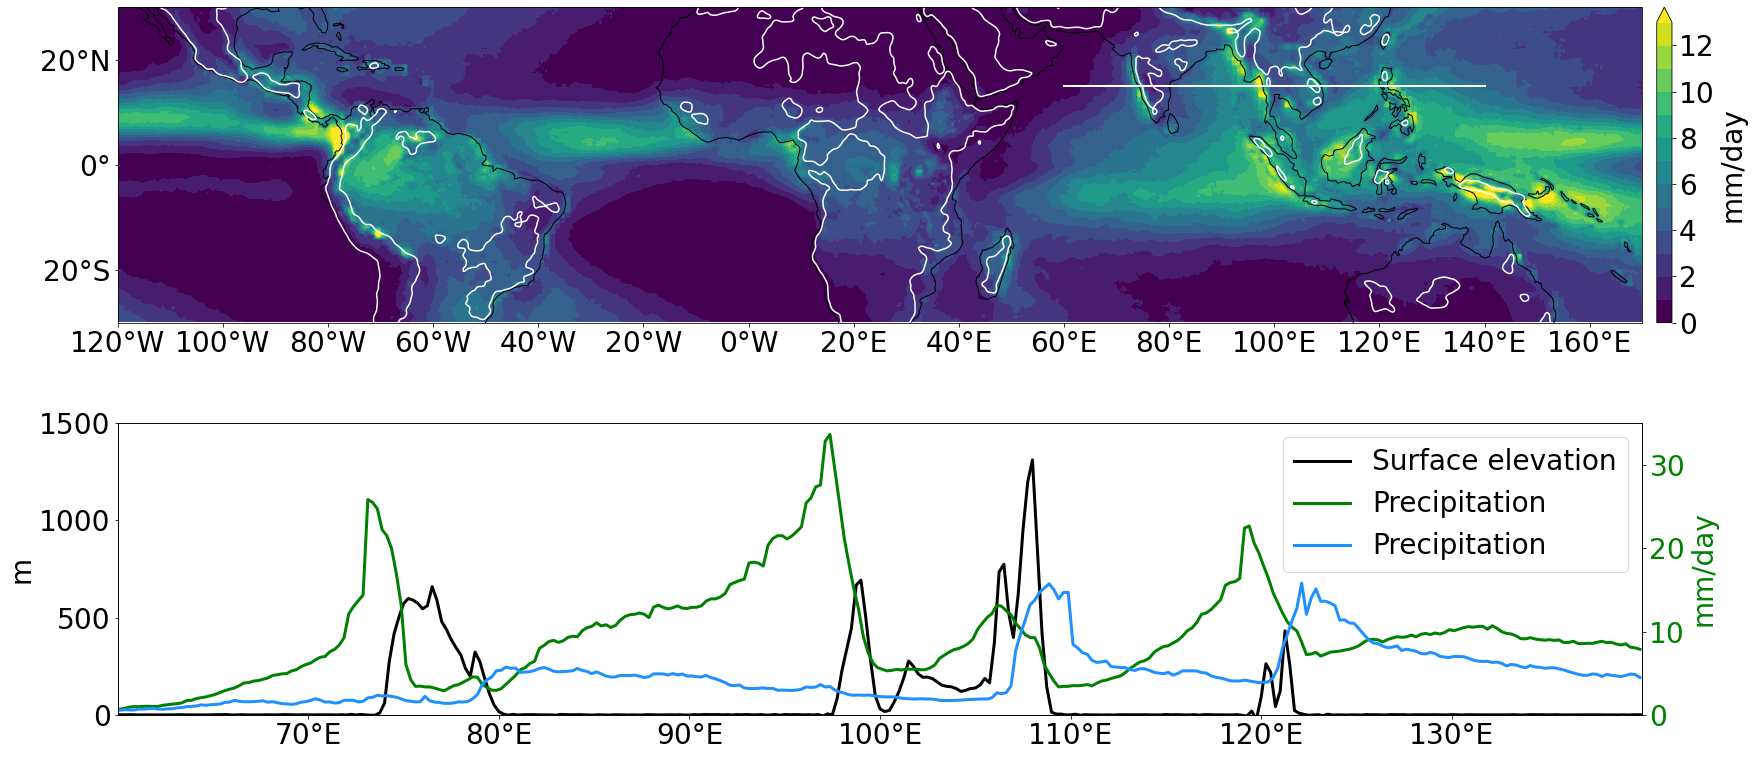

In [408]:
matplotlib.rcParams.update({'font.size': 28})
fig = plt.figure(figsize=(25,12))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [3, 2],figure=fig)
ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[1])

cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#,cbar_kwargs={'label':'mm/day'}
orog_plot_smooth.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1.5])
ax.plot([60,140],[15,15],color='w',linewidth=2)

ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label='mm/day')

ax3=cross_section(60,140,15,ax2)
for a in ax2,ax3:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    cax2.remove()
ax2.set_ylim(0,1500)
ax3.set_ylim(0,35)
ax2.set_ylabel("m")
ax3.tick_params(axis ='y', labelcolor = 'g')
ax3.set_ylabel("mm/day",color='g')
fig.tight_layout()

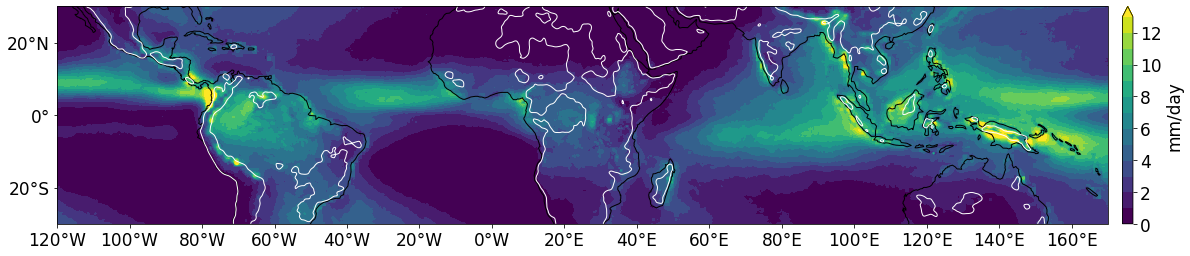

In [16]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#
orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])

ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label='mm/day')

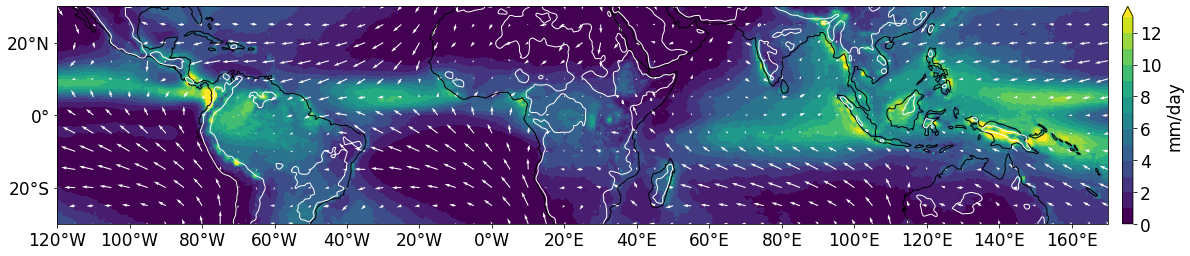

In [20]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#
orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])

u=u100plot.sel(longitude=slice(-120,170)).mean('month')
v=v100plot.sel(longitude=slice(-120,170)).mean('month')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=20
m=n
ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=600)



ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label='mm/day')

# Figure 2 - Theory precip & CAPE

In [243]:
from scipy.integrate import cumtrapz
width = 10000e3
mwidth = 200e3
mcenter = 5000e3

def domain():
    return np.linspace(0,width,100000)
def precip(cape,tau_c):
    """Compute a precipitation in mm/day (Pr = CAPE/tau_c/LatentHeat)"""
    Lc = 2.26e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    conversion = 86400
    return conversion * M * cape / tau_c / Lc
def cape_analytical_Lx(x,f,L,CAPERCE,alpha):
    """Analytical solution to equation (3), with L and CAPERCE varying with x"""
    c = cumtrapz(1/(f*L),x,initial=0)
    return CAPERCE * np.exp(-c) * (1+cumtrapz(alpha/L*np.exp(c),x,initial=0))
def solve_Lx(f,L,CAPERCE,alpha,tau_c0):
    x = domain()
    capea = cape_analytical_Lx(x,f(x),L,CAPERCE,alpha)
    pr = precip(capea,tau_c0*f(x))
    return x,capea,pr

def f_square(x,strength):
    return 1 - (x>mcenter - mwidth/2)*(x<mcenter + mwidth/2)*(1-strength) #+ (x>mcenter + mwidth/2)*(x<mcenter + 3*mwidth/2)*(1/strength-1)

def elu(x):
    return (x<0)*(np.exp(np.minimum(x,200))-1)+(x>=0)*x
#def f_sim_s(x,strength,dstrength):
#    m = mcenter
#    sigma = 1.5*mwidth/2
#    gauss = 1 - (1-strength)*np.exp(-(x-m)**2/(2*sigma**2))
#    arg=(-(5+(dstrength-5)/2)*elu(-(x-mcenter)/mwidth*3)-elu(0.5*(x-mcenter)/mwidth))
#    downstream=dstrength*np.exp(arg)/np.exp(arg).max()
#    return gauss+downstream
#

def f_legendre(x,strength):
    arg = (x-mcenter-mwidth/2)/mwidth*1.7
    return np.exp(-np.log(strength)/0.6*arg*np.exp(-(arg)**2/2))

L=500e3
CAPERCE=1000.
tau_c0 = 60e3

In [244]:
def triangles(x,strength,dstrength,log=False):
    a=mcenter-1.*mwidth   #mcenter-1.5*mwidth
    b=mcenter#-0.5*mwidth/2   #mcenter-0.5*mwidth/2
    c=b#mcenter+0.5*mwidth/2   #mcenter+0.5*mwidth/2
    d=mcenter+2*mwidth/2   #mcenter+1.5*mwidth/2
    e=mcenter+4.5*mwidth   #mcenter+4.5*mwidth
    upstream=1.
    if log:
        upstream=0.
        strength=np.log(strength)
        dstrength=np.log(dstrength)
        
    if x < a or x > e:
        return upstream
    elif x < b :
        return upstream + (strength-upstream)/(b-a)*(x-a)
    elif x < c:
        return strength
    elif x < d:
        return strength + (dstrength-strength)/(d-c) * (x-c)
    else:
        return dstrength + (upstream-dstrength)/(e-d)*(x-d)
    
triangles=np.vectorize(triangles,excluded=(1,2))
f_sim_s=lambda x,strength,dstrength: np.exp(np.convolve(triangles(x,strength,dstrength,log=True), np.ones(500)/500, mode='same'))
#f_sim_s=lambda x,strength,dstrength: np.convolve(triangles(x,strength,dstrength), np.ones(1000)/1000, mode='same')


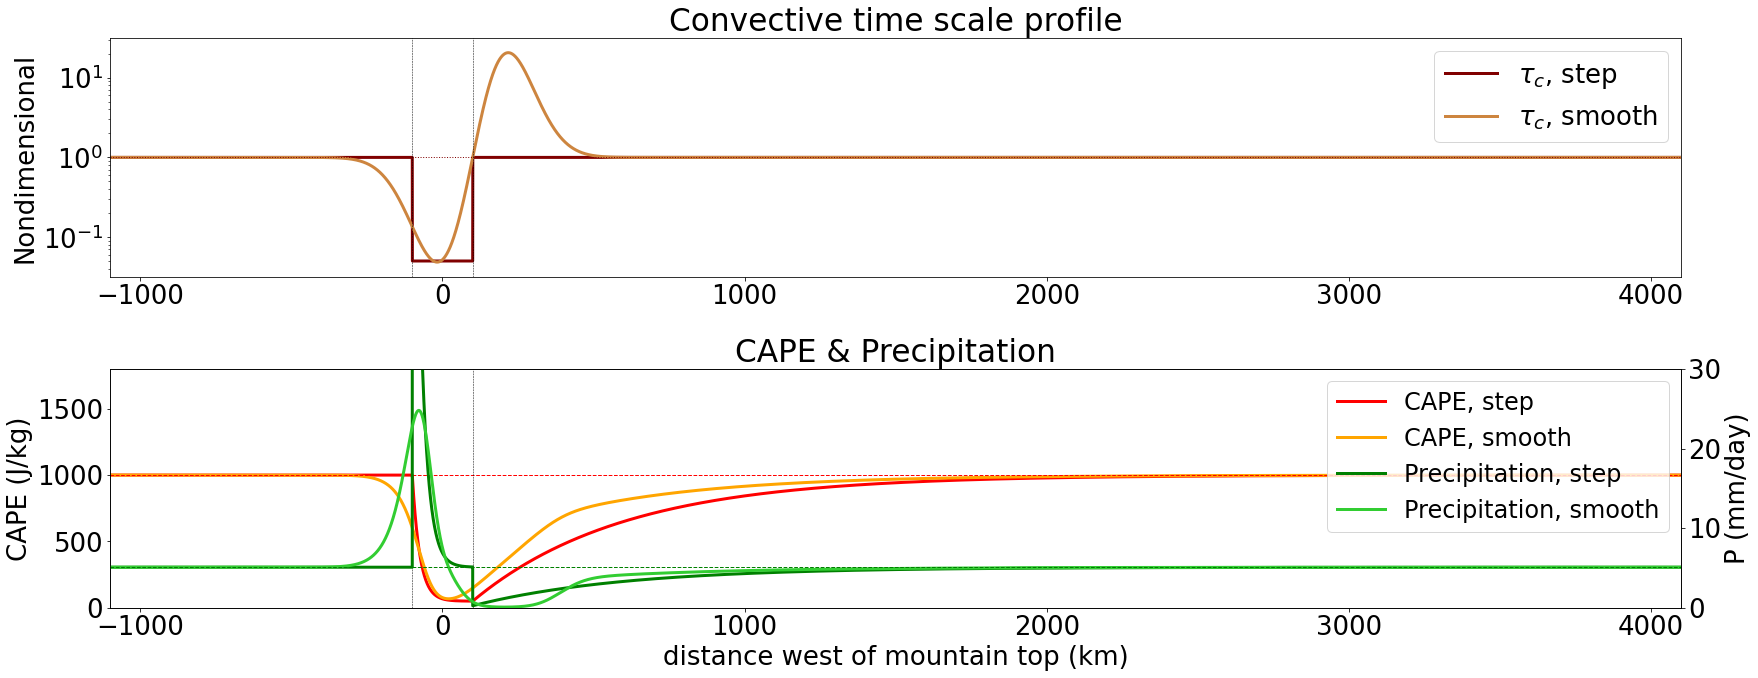

In [248]:
matplotlib.rcParams.update({'font.size': 26})
x = domain()
x,CAPE_squ,pr_squ = solve_Lx(lambda x : f_square(x,0.05) ,L,CAPERCE,1.,tau_c0)
x,CAPE_sim,pr_sim = solve_Lx(lambda x : f_legendre(x,0.05),L,CAPERCE,1.,tau_c0)
#x,CAPE_sim,pr_sim = solve_Lx(lambda x : f_sim_s(x,0.04,21),L,CAPERCE,1.,tau_c0)

fig,(ax0,ax)=plt.subplots(2,1,figsize=(25,10))
ax2=ax.twinx()

# Convective time scales
ax0.plot(x/1000-5000,f_square(x,0.05) ,label=r"$\tau_c$, step",color='maroon',linewidth=3)
ax0.plot(x/1000-5000,f_legendre(x,0.05),label=r"$\tau_c$, smooth",color='peru',linewidth=3)

# ax0 decoration
ax0.axhline(1.,color='maroon',linestyle=':',linewidth=1)
ax0.axvline(- mwidth/2000,color='k', linestyle='--',linewidth=0.5)
ax0.axvline(  mwidth/2000,color='k', linestyle='--',linewidth=0.5)
ax0.set_title('Convective time scale profile')
ax0.legend()
ax0.set_ylabel('Nondimensional')
ax0.set_yscale('log')
ax0.set_ylim(10**(-1.5),10**1.5)

# CAPE,Pr
ax.plot(x/1000-5000,CAPE_squ,label="CAPE, step",color='r',linewidth=3)
ax2.plot(x/1000-5000,pr_squ,label="Precipitation, step",color='g',linewidth=3)

#ax.plot(x/1000-5000,CAPE_sim,label="CAPE, smooth",        linestyle='--',color='r',linewidth=3)
#ax2.plot(x/1000-5000,pr_sim,label="Precipitation, smooth",linestyle='--',color='g',linewidth=3)

ax.plot(x/1000-5000,CAPE_sim,label="CAPE, smooth",        color='orange',linewidth=3)
ax2.plot(x/1000-5000,pr_sim,label="Precipitation, smooth",color='limegreen',linewidth=3)


# ax,ax2 decoration
ax.axhline(CAPERCE ,color='r',linestyle='--',linewidth=1)
ax2.axhline(86400 * 8e3 * CAPERCE / tau_c0 / 2.26e6,color='g',linestyle='--',linewidth=1)
ax.axvline(- mwidth/2000,color='k', linestyle='--',linewidth=0.5)
ax.axvline(  mwidth/2000,color='k', linestyle='--',linewidth=0.5)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0,fontsize=24)

ax.set_title("CAPE & Precipitation")
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("CAPE (J/kg)")
ax2.set_ylabel('P (mm/day)')
ax.set_ylim(0,1800)
ax2.set_ylim(0,30)
ax0.set_xlim(-1100,4100)
ax.set_xlim(-1100,4100)

fig.tight_layout()

# Figure 3 - WRF Precip, CAPE & $\tau_c$

In [196]:
hrpr=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()
hrcape=hrchannel_capecin[0].isel(Time=slice(200,801)).mean(['Time','south_north']).load()

factor = 8000/(2.26e6/86400)
hrtau = hrcape/hrpr*factor

In [197]:
%%time
hrpr_intervals   = np.zeros((15,len(hrchannel.west_east)))
hrcape_intervals = np.zeros((15,len(hrchannel.west_east)))
hrtauc_intervals = np.zeros((15,len(hrchannel.west_east)))
for i,t in enumerate(range(200,800,40)):
    hrpr_intervals[i]=np.array(hrchannelprecip.isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    hrcape_intervals[i]=np.array(hrchannel_capecin[0].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    hrtauc_intervals[i]=hrcape_intervals[i]/hrpr_intervals[i]*factor

CPU times: user 1.42 s, sys: 1.54 s, total: 2.96 s
Wall time: 2.89 s


In [198]:
from matplotlib.colors import to_rgb
to_rgb('maroon')

(0.5019607843137255, 0.0, 0.0)

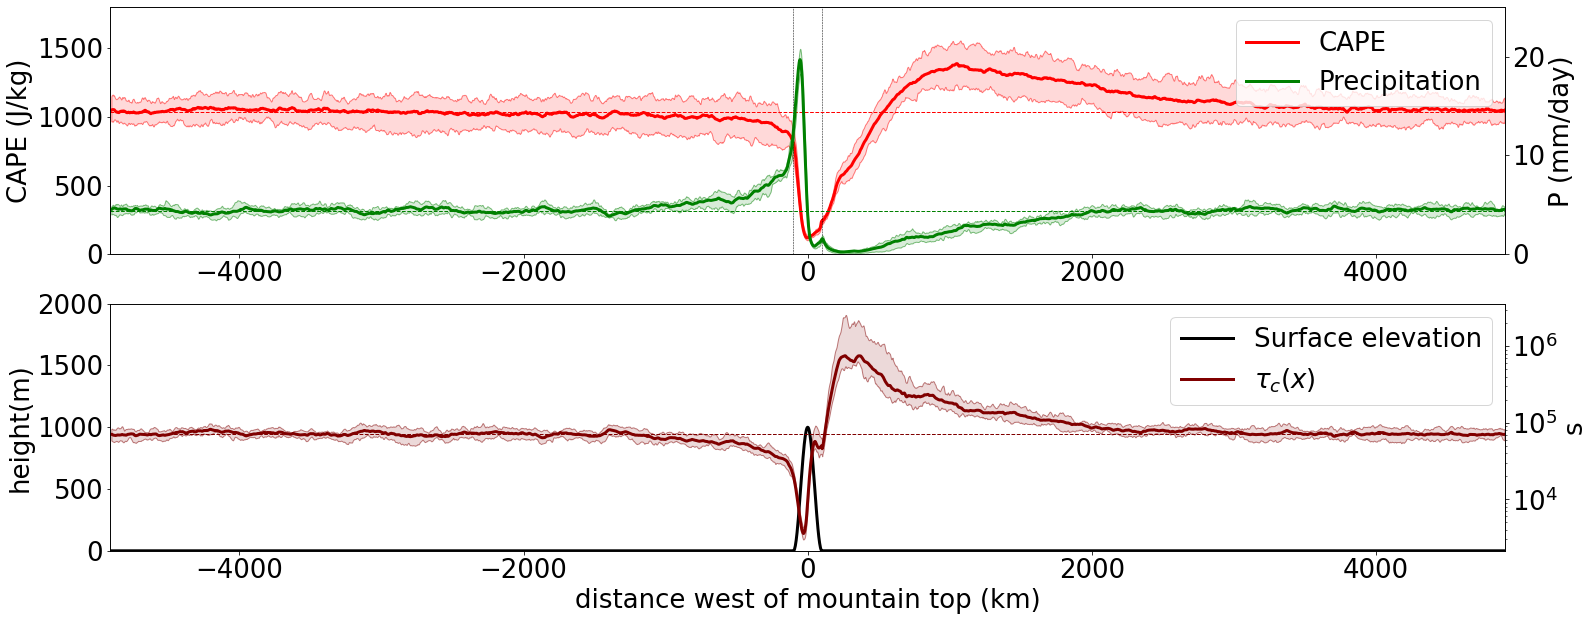

In [199]:
matplotlib.rcParams.update({'font.size': 26})

_,(axca,axmt)=plt.subplots(2,1,figsize=(25,10))
axpr=axca.twinx()
axta=axmt.twinx()

#PANEL 1 - Precip & CAPE

axca.plot(hrdist,hrcape,label="CAPE",color='r',linewidth=3)
axpr.plot(hrdist,hrpr,label="Precipitation",color='g',linewidth=3)

axca.fill_between(hrdist,np.percentile(hrcape_intervals,25,axis=0),np.percentile(hrcape_intervals,75,axis=0),facecolor=(1.,0,0,.15), edgecolor=(1.,0,0,.5))
axpr.fill_between(hrdist,np.percentile(hrpr_intervals,25,axis=0),np.percentile(hrpr_intervals,75,axis=0),facecolor=(0,0.5,0,.15), edgecolor=(0,0.5,0,.5))


axca.axvline(- 100,color='k', linestyle='--',linewidth=0.5)
axca.axvline(  100,color='k', linestyle='--',linewidth=0.5)
axca.axhline(hrcape[2000:3000].mean(),color='r',linestyle='--',linewidth=1)
axpr.axhline(hrpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)

linesca,labelsca = axca.get_legend_handles_labels()
linespr,labelspr = axpr.get_legend_handles_labels()
axpr.legend(linesca + linespr, labelsca + labelspr, loc=0)

axca.set_xlim(-4910,4910)
axca.set_ylabel("CAPE (J/kg)")
axpr.set_ylabel('P (mm/day)')
axca.set_ylim(0,1800)
axpr.set_ylim(0,25)

#PANEL 2 - MOUNTAIN & Tau_c


axmt.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
axta.plot(hrdist,hrtau,label=r"$\tau_c(x)$",linewidth=3,color="maroon")
axta.axhline(hrtau[2000:3000].mean(),linewidth=1,linestyle='--',color="maroon")

axta.fill_between(hrdist,np.percentile(hrtauc_intervals,25,axis=0),np.percentile(hrtauc_intervals,75,axis=0),facecolor=(0.5,0.,0,.15), edgecolor=(0.5,0.,0,.5))


linesmt, labelsmt = axmt.get_legend_handles_labels()
linesta, labelsta = axta.get_legend_handles_labels()
axta.legend(linesmt + linesta, labelsmt + labelsta, loc=0)

axmt.set_xlabel("distance west of mountain top (km)")
axmt.set_ylabel("height(m)")
axta.set_ylabel('s')
axmt.set_ylim(0,2000)
axmt.set_xlim(-4910,4910)
#axta.set_ylim(10**(-2),10**2)
axta.set_yscale('log')

fig.tight_layout()

# Figure 4 - x-z cross sections of vertical motion, from moist & dry simulations

In [10]:
wmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),staggered=True)
wdrymean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),staggered=True)

wdrymean_p = interp_eta_to_pressure(hrchannel,wdrymean_s)
wmean_p = interp_eta_to_pressure(hrchannel,wmean_s)


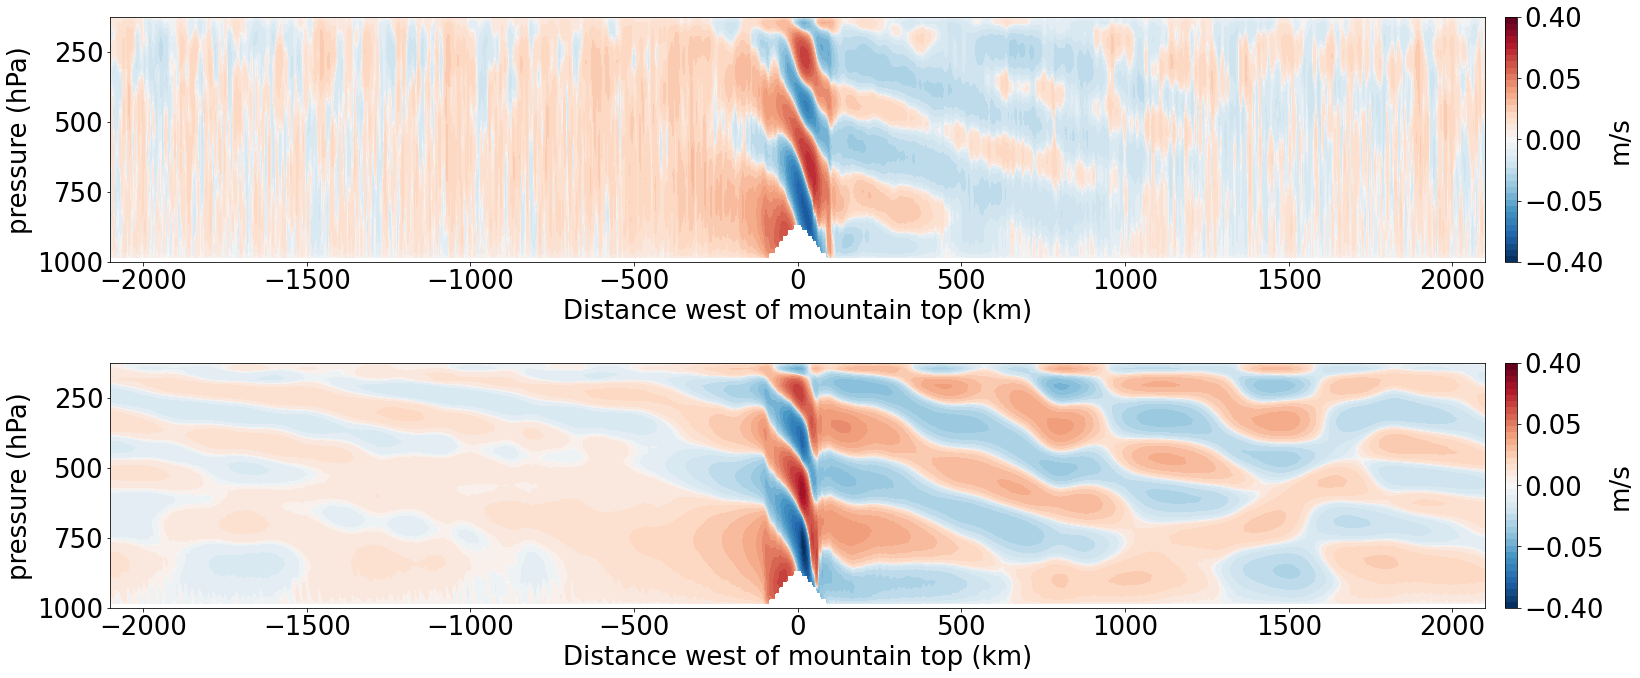

In [219]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

fig,ax=plt.subplots(2,1,figsize=(25,10))
wlevs=levs(0.4,3)
wticks=[-.5,-.4,-.05,0.,.05,.4,.5]

wmean_p.plot.contourf(ax=ax[0],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'m/s','pad':.012})#,cmap=plt.cm.RdBu)
wdrymean_p.plot.contourf(ax=ax[1],yincrease=False, levels=wlevs,cbar_kwargs={'ticks':wticks, 'label':'m/s','pad':.012})

for a in ax:
    a.set_xlabel("Distance west of mountain top (km)")
    a.set_ylabel("pressure (hPa)")
    a.set_xlim(-2100,2100)
    a.set_yticks([250,500,750,1000])
fig.tight_layout()


# Figure 5 - x-y cross section of vertical motion at 500hPa

In [213]:
#%%time
#def change_coords_sn(var):
#    return var.assign_coords({'distance_ns':3*var.south_north}).swap_dims({'south_north':'distance_ns'})
#
#ndays=1
#w_day152 = change_coords_sn(change_coords_pl(hrchannel_p,hrchannel_p.W_PL.isel(Time=slice(3648,3648+ndays*24)).squeeze())).sel(distance_from_mtn=slice(400,-400))
#w_day152=w_day152.where(w_day152>-100).fillna(0.)
#w_day152=w_day152.sel(pressure=500.).persist()
#w_day152.to_netcdf("/global/cscratch1/sd/qnicolas/temp/wrf.W.day152.500hPa.nc")

CPU times: user 0 ns, sys: 11min 22s, total: 11min 22s
Wall time: 12min 50s


In [216]:
w_day152=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/wrf.W.day152.500hPa.nc")

Text(0.5, 1.0, '')

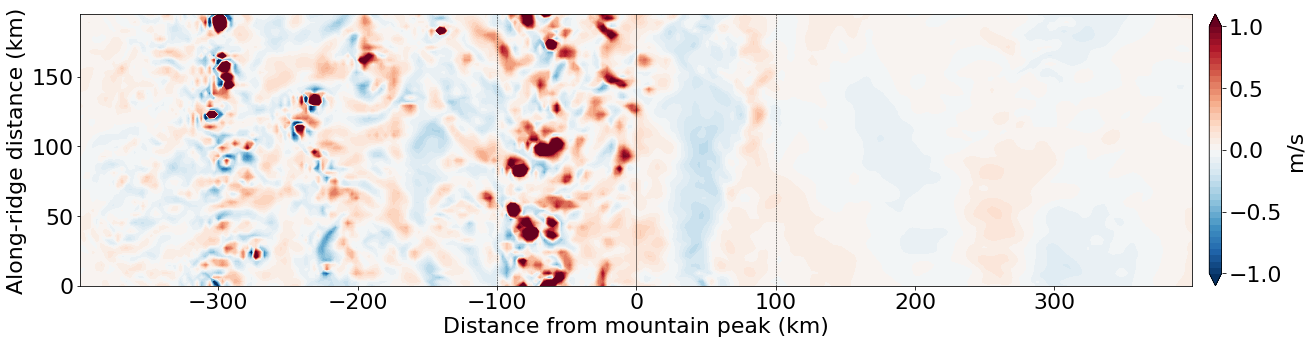

In [233]:
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(1,1,figsize=(25,5))

wscale=1.
wlevs=np.linspace(-wscale,wscale,41)
wticks=np.arange(-1.5,1.6,0.5)
i=19

ax.axvline(   0.,color='k',linewidth=0.5)
ax.axvline(-100.,color='k',linewidth=0.5,linestyle='--')
ax.axvline( 100.,color='k',linewidth=0.5,linestyle='--')
w_day152.isel(Time=i).plot.contourf(ax=ax,levels=wlevs,cbar_kwargs={'ticks':wticks,'label':'m/s','pad':.012})
ax.set_aspect("equal")
ax.set_xlabel("Distance from mountain peak (km)")
ax.set_ylabel("Along-ridge distance (km)")
ax.set_title("")

# Figure 6 - Thermo equation breakdown

In [12]:
def select_time(ds):
    return ds.isel(Time=slice(200,300))
def select_lon(ds):
    return ds.isel(num_press_levels_stag=slice(5,-4),west_east=slice(1135,2135))

In [13]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')

umean = umean.where(umean >-30.)  
rhomean = rhomean.where(rhomean >0.)  
wmean   = wmean.where(wmean > -10)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean

In [40]:
%%time
PPL=hrchannel_p.P_PL.isel(Time=0).load()
meanThetaPL = (tmean*(PPL/1e5)**(-0.286)).persist()

# Advective term
meandThetadx = select_lon(meanThetaPL).differentiate('west_east')/3000   # in K/meter
#meandThetady = select_lon(meanThetaPL).differentiate('south_north')/3000 # in K/meter
meanugradTheta = ((select_lon(umean)*meandThetadx)*86400).persist() #in K/day #+select_lon(vmean)*meandThetady

# Adiabatic term
meanomegadThetadp = (select_lon(omegamean)*select_lon(meanThetaPL.assign_coords({'pressure':PPL})).differentiate('pressure')*86400).persist() #in K/day

# Radiative heating term
meanQrad = select_time(hrchannel.RTHRATEN).mean('Time')*86400
meanQrad_pi = meanQrad/(hrchannel.PB[100,:,0]/1e5)**0.286
meanQrad_pi = interp_pressure(meanQrad_pi).mean('south_north')[4:,1135:2135]

meanQrad_pi = xr.DataArray(np.array(meanQrad_pi),coords=meanomegadThetadp.coords)

# diabatic heating term
meanQdiab_pi = meanugradTheta + meanomegadThetadp - meanQrad_pi

CPU times: user 6.27 s, sys: 8.17 s, total: 14.4 s
Wall time: 14.2 s


In [41]:
def pressure_avg(ds):
    ds=ds.assign_coords({'pressure':PPL[5:-4]})
    return -ds.fillna(0.).integrate('pressure')/np.abs(ds.pressure[0]-ds.pressure[-1])

pmeanugradTheta   =pressure_avg(meanugradTheta    ).load()
pmeanomegadThetadp=pressure_avg(meanomegadThetadp ).load()
pmeanQrad_pi      =pressure_avg(meanQrad_pi       ).load()
pmeanQdiab_pi     =pressure_avg(meanQdiab_pi      ).load()

In [505]:
%%time

# Advective term
meanTheta = interp_pressure(select_time(hrchannel.T).mean('Time'))
meandThetadx = meanTheta.differentiate('west_east')/3000   # in K/meter
meandestag_U = interp_pressure(wrf.destagger(select_time(hrchannel.U).mean('Time'),2,meta=True))
mean2ugradTheta = ((meandestag_U*meandThetadx)*86400).persist() #in K/day

# Adiabatic term
meandestag_W = interp_pressure(wrf.destagger(select_time(hrchannel.W).mean('Time'),0,meta=True))
meanRHO = interp_pressure(select_time(hrchannel.RHO).mean('Time'))
meandThetadp = meanTheta.differentiate('pressure')/100.

mean2omegadThetadp = (-9.81*meanRHO*meandestag_W*meandThetadp*86400).persist() #in K/day

CPU times: user 17.6 s, sys: 15min 21s, total: 15min 38s
Wall time: 10min 53s


In [526]:
def pressure_sn_avg(ds):
    return -ds[4:,:,1135:2135].fillna(0.).integrate('pressure').mean('south_north')/np.abs(ds.pressure[0]-ds.pressure[-1])

pmean2ugradTheta   =pressure_sn_avg(mean2ugradTheta    )
pmean2omegadThetadp=pressure_sn_avg(mean2omegadThetadp )
pmean2Qdiab_pi     =pmean2ugradTheta+pmean2omegadThetadp-pmeanQrad_pi

In [64]:
%%time
def select_time2(ds):
    return ds.isel(Time=slice(200,400))

# Advective term
drymeanTheta = interp_pressure(select_time2(dryhrchannel.T).mean('Time'))
drymeandestag_U = interp_pressure(wrf.destagger(select_time2(dryhrchannel.U).mean('Time'),2,meta=True))

# Adiabatic term
drymeandestag_W = interp_pressure(wrf.destagger(select_time2(dryhrchannel.W).mean('Time'),0,meta=True))
drymeanRHO = interp_pressure(select_time2(dryhrchannel.RHO).mean('Time'))

CPU times: user 53.1 s, sys: 4min 27s, total: 5min 20s
Wall time: 3min 42s


In [12]:
def pressure_sn_avg(ds):
    return -ds[4:,:,1135:2135].fillna(0.).integrate('pressure').mean('south_north')/np.abs(ds.pressure[0]-ds.pressure[-1])

drymeandThetadx = drymeanTheta.differentiate('west_east')/3000   # in K/meter
drymeanugradTheta = ((drymeandestag_U*drymeandThetadx)*86400).persist() #in K/day
drymeandThetadp = drymeanTheta.differentiate('pressure')/100.
drymeanomegadThetadp = (-9.81*drymeanRHO*drymeandestag_W*drymeandThetadp*86400).persist() #in K/day

drypmeanugradTheta   =pressure_sn_avg(drymeanugradTheta    )
drypmeanomegadThetadp=pressure_sn_avg(drymeanomegadThetadp )
drypmeanQdiab_pi     =drypmeanugradTheta+drypmeanomegadThetadp

In [13]:
def snmean(ds):
    return ds[4:,:,1135:2135].mean('south_north')
drymean2ugradTheta = (snmean(drymeandestag_U)*snmean(drymeanTheta).differentiate('west_east')/3000*86400).persist()
drymean2omegadThetadp = (-9.81*snmean(drymeanRHO)*snmean(drymeandestag_W)*snmean(drymeanTheta).differentiate('pressure')/100.*86400).persist()

In [14]:
def pressure_avg2(ds):
    return -ds.fillna(0.).integrate('pressure')/np.abs(ds.pressure[0]-ds.pressure[-1])

drypmean2ugradTheta   =pressure_avg2(drymean2ugradTheta    )
drypmean2omegadThetadp=pressure_avg2(drymean2omegadThetadp )
drypmean2Qdiab_pi     =drypmean2ugradTheta+drypmean2omegadThetadp

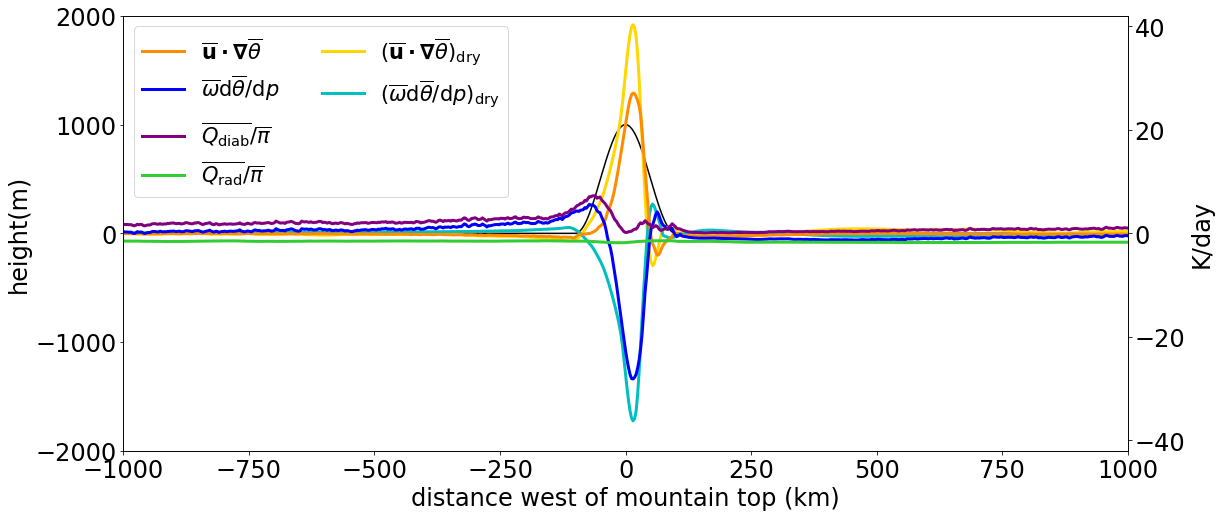

In [77]:
import matplotlib.legend as mlegend
matplotlib.rcParams.update({'font.size': 24})
dist=(500-pmeanugradTheta.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()

ax.plot(dist,hrhgt[1135:2135],color='k')

l1,=ax2.plot(dist, drypmean2ugradTheta   .rolling(west_east=10,center=True).mean(),linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"     ,color="gold")
l2,=ax2.plot(dist, drypmean2omegadThetadp.rolling(west_east=10,center=True).mean(),linewidth=3,label=r"$(\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p)_\mathrm{dry} $",color="c")
#ax2.plot(dist, drypmean2Qdiab_pi     .rolling(west_east=10,center=True).mean(),label="Qdiab over pi", color="violet")

#\dfrac{\mathrm{d}\overline{\theta}}{\mathrm{d}p}

l3,=ax2.plot(dist, pmeanugradTheta   ,linewidth=3,label=r"$\mathbf{\overline{u} \cdot \nabla } \overline{\theta}$"     , color="darkorange")
l4,=ax2.plot(dist, pmeanomegadThetadp,linewidth=3,label=r"$\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p $", color="b")
l5,=ax2.plot(dist, pmeanQdiab_pi     ,linewidth=3,label=r"$\overline{Q_\mathrm{diab}}/\overline{\pi}$", color="purple")
l6,=ax2.plot(dist, pmeanQrad_pi      ,linewidth=3,label=r"$\overline{Q_\mathrm{rad}}/\overline{\pi}$", color='limegreen')

ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-2000,2000)
ax.set_xlim(-1000,1000)
ax.set_yticks(range(-2000,2001,1000))

ax2.set_ylabel("K/day")
ax2.set_ylim(-42,42)
ax2.set_yticks(range(-40,41,20))
#ax2.legend(loc=1,ncol=2,fontsize=20)


leg1 = ax2.legend([l3,l4,l1,l2], [l3._label,l4._label,l1._label,l2._label], ncol=2,loc=2,fontsize=21)
leg2 = mlegend.Legend(ax2, [l5, l6], [l5._label, l6._label], ncol=1,fontsize=21)

leg1._legend_box._children.append(leg2._legend_box._children[1])
leg1._legend_box.align="left" # the default layout is 'center'


# Figure 7 - moisture deviation profiles

In [243]:
# Jordan Sounding
pjordan = 100*np.array([100.,125.,150.,175.,200., 250., 300., 350., 400., 450., 500., 550., 600.,650., 700., 750., 800., 850., 900., 950.,1000.,1016.3])
Tjordan = 273.15+np.array([-74.6,-71.5,-66.7,-61.,-55.3,-44.2,-34.5,-26.1,-18.9,-12.8,-7.6,-3.,1.,4.6,7.9,10.7,13.1,15.6,18.3,21.2,24.3,24.7])
pjordan=pjordan[4:]
Tjordan=Tjordan[4:]
b1 = qsat(Tjordan,pjordan/100)/qsat(Tjordan,pjordan/100)[-1]
b1 = xr.DataArray(b1[::-1],coords= {"pressure":pjordan[::-1]/100},dims=["pressure"])

In [375]:
from scipy.interpolate import lagrange
p=qmean_s.pressure[:,0]
p=np.linspace(0,1000,200)
def b1new_func(p):
    ps = [0.,500.,855.,935.,1000.]
    bs = [0.,0.,-.2,1.1,0.]
    for i in range(len(ps)-1):
        if p >=ps[i] and p<=ps[i+1]:
            return bs[i]+(bs[i+1]-bs[i])/(ps[i+1]-ps[i])*(p-ps[i])
b1new_func=np.vectorize(b1new_func)
b1new_func2=lambda p: xr.DataArray(np.convolve(b1new_func(p), np.ones(6)/6, mode='same'),coords= {"pressure":np.array(p)},dims=["pressure"])
b1new=b1new_func2(p)
b1new[-1]=0.
#b1new = np.concatenate([np.convolve(b1new, np.ones(30)/30, mode='valid')[:-20],b1new[-49:]])
#b1new = xr.DataArray(b1new,coords= {"pressure":np.array(p)},dims=["pressure"])

#b1new = np.exp((p-950)/40)*(1-0.7*np.exp((p-988)/20)) - (np.arctan((p-500)/100)/np.pi+0.5)/8
#b1new=(b1new/b1new.max()).swap_dims({'eta_level':'pressure'})

In [354]:
qmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc')
qmean_s   = change_coords_eta(hrchannel,qmean_s  )

In [288]:
qdiff=-(qmean_s.sel(distance_from_mtn=slice(1000,300))-qmean_s.sel(distance_from_mtn=-3000,method='nearest'))
qprofile = (qdiff/qdiff.max(dim='eta_level')).mean('distance_from_mtn').assign_coords({'pressure':qmean_s[:,0].pressure}).swap_dims({'eta_level':'pressure'})

In [374]:
print("%.3f"%pressure_mean(b1new))

print("%.3f"%pressure_mean(qprofile))


0.093
0.007


Text(0, 0.5, 'pressure (hPa)')

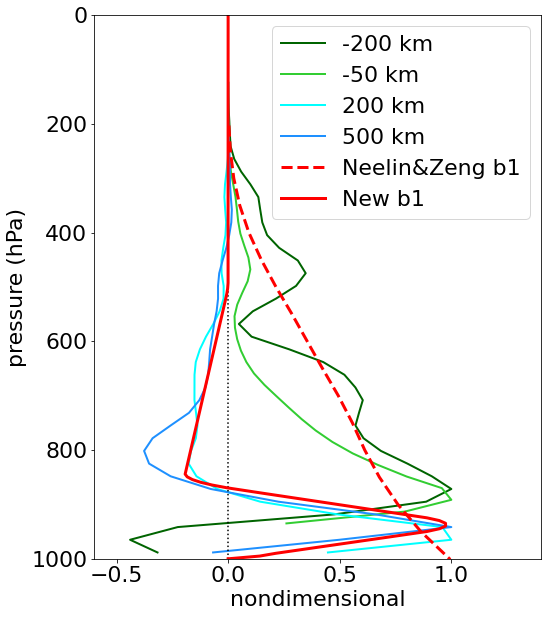

In [389]:
_,ax=plt.subplots(1,1,figsize=(8,10))
lw=3
colors=['darkgreen','limegreen','aqua','dodgerblue']
for i,(d1,d2) in enumerate(zip([-3000]*5,[-200,-50,200,500])):
    q2=qmean_s.sel(distance_from_mtn=d2,method='nearest').swap_dims({'eta_level':'pressure'})
    q1=qmean_s.sel(distance_from_mtn=d1,method='nearest').swap_dims({'eta_level':'pressure'}).interp_like(q2)
    diff = np.sign((q2-q1)[3])*(q2-q1)
    (diff/diff.max()).plot(ax=ax,y='pressure',yincrease=False,label="%i km"%d2,color=colors[i],linewidth=2)
#qprofile.plot(ax=ax,y='pressure',yincrease=False)
ax.axvline(0.,linestyle=':',color='k')
b1.plot(ax=ax,y='pressure',yincrease=False,label='Neelin&Zeng b1',color='r',linestyle='--',linewidth=lw)
b1new.plot(ax=ax,y='pressure',yincrease=False,label='New b1',color='r',linewidth=lw)
ax.legend(loc=1)
ax.set_title("")
ax.set_ylim(1000.,0.)
ax.set_xlim(-0.6,1.4)
ax.set_xlabel("nondimensional")
ax.set_ylabel("pressure (hPa)")

# Figure 8 - Precip and CAPE, analytical theory with model $\tau_c$

In [11]:
hrCAPERCE = 1050
L=450e3
hrtauc0=7e4

# f from simulation
x = 1000*(1635-hrhgt.west_east)*3 #+ 4902000
x = x[::-1] 

hrcape=hrchannel_capecin[0].isel(Time=slice(200,800)).mean(['south_north','Time']).load()
hrpr = hrchannelprecip.isel(Time=slice(200,800)).mean(['south_north','Time']).load()
hrtauc=hrcape/(2.26e6*hrpr/86400/8000)
hrfsim = np.array(hrtauc[::-1]/hrtauc.isel(west_east=slice(2000,3000)).mean())
print("baseline tau_c in hr simulation : %.1e s"%(hrtauc.isel(west_east=slice(2000,3000)).mean()))

baseline tau_c in hr simulation : 7.2e+04 s


In [38]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
hrradc = rad_cooling(hrchannel.isel(Time=slice(200,800))).mean(['south_north'])
hrevap = hrchannel.QFX.isel(Time=slice(200,800)).mean(['south_north','Time'])

In [103]:
%%time
Ms = 2800
Mh = 800
Mq = Ms-Mh
hralpha = np.array((Ms*hrevap/hrevap.mean()-Mq*hrradc/hrradc.mean())/Mh)[::-1]
hralpha_evap1 = np.maximum(0.,np.array((Ms*hrevap/hrevap[2000:3000].mean()-Mq)/Mh)[::-1])
hralpha_evaponly = np.array(hrevap/hrevap.mean())[::-1]
hralpha_radconly = np.array(hrradc/hrradc.mean())[::-1]

CPU times: user 2.48 s, sys: 4.6 s, total: 7.07 s
Wall time: 13.1 s


In [87]:
Qrad = select_time(hrchannel.RTHRATEN).mean('Time')*86400
Qrad_pi = meanQrad/(hrchannel.PB[100,:,0]/1e5)**0.286
Qrad_pi = interp_pressure(Qrad_pi).mean('south_north')[4:]
Qrad_pi

nQrad_pi      =Qrad_pi.fillna(0.).integrate('pressure')/np.abs(Qrad_pi.pressure[0]-Qrad_pi.pressure[-1])

In [98]:
hralpha_radconly2 = np.array(nQrad_pi/nQrad_pi[2000:3000].mean())[::-1]

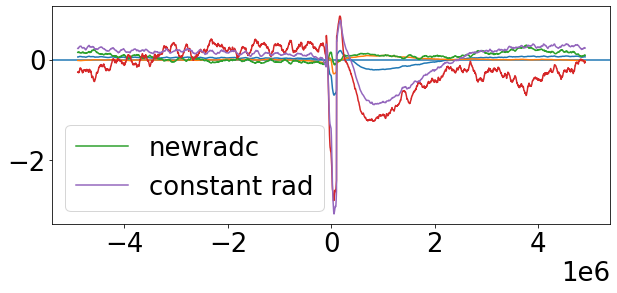

In [99]:
plt.figure(figsize=(10,4))
plt.axhline(0.)
plt.plot(x,hralpha_evaponly-1)
plt.plot(x,hralpha_radconly-1)
plt.plot(x,hralpha_radconly2-1,label='newradc')

plt.plot(x,(hralpha_evaponly-1)*26/6 - 20/6*(hralpha_radconly2-1))
plt.plot(x,(hralpha_evaponly-1)*26/6,label="constant rad")
plt.legend()

In [104]:
hrcape_analytical_alpha1 = cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,1.)
hrpr_analytical_alpha1 = precip(hrcape_analytical_alpha1,hrtauc0*hrfsim)

hrcape_analytical_alphaer = cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,hralpha_evap1)
hrpr_analytical_alphaer = precip(hrcape_analytical_alphaer,hrtauc0*hrfsim)

hrcape_analytical_alphae = cape_analytical_Lx(x,hrfsim,L,hrCAPERCE,hralpha_evaponly)
hrpr_analytical_alphae = precip(hrcape_analytical_alphae,hrtauc0*hrfsim)


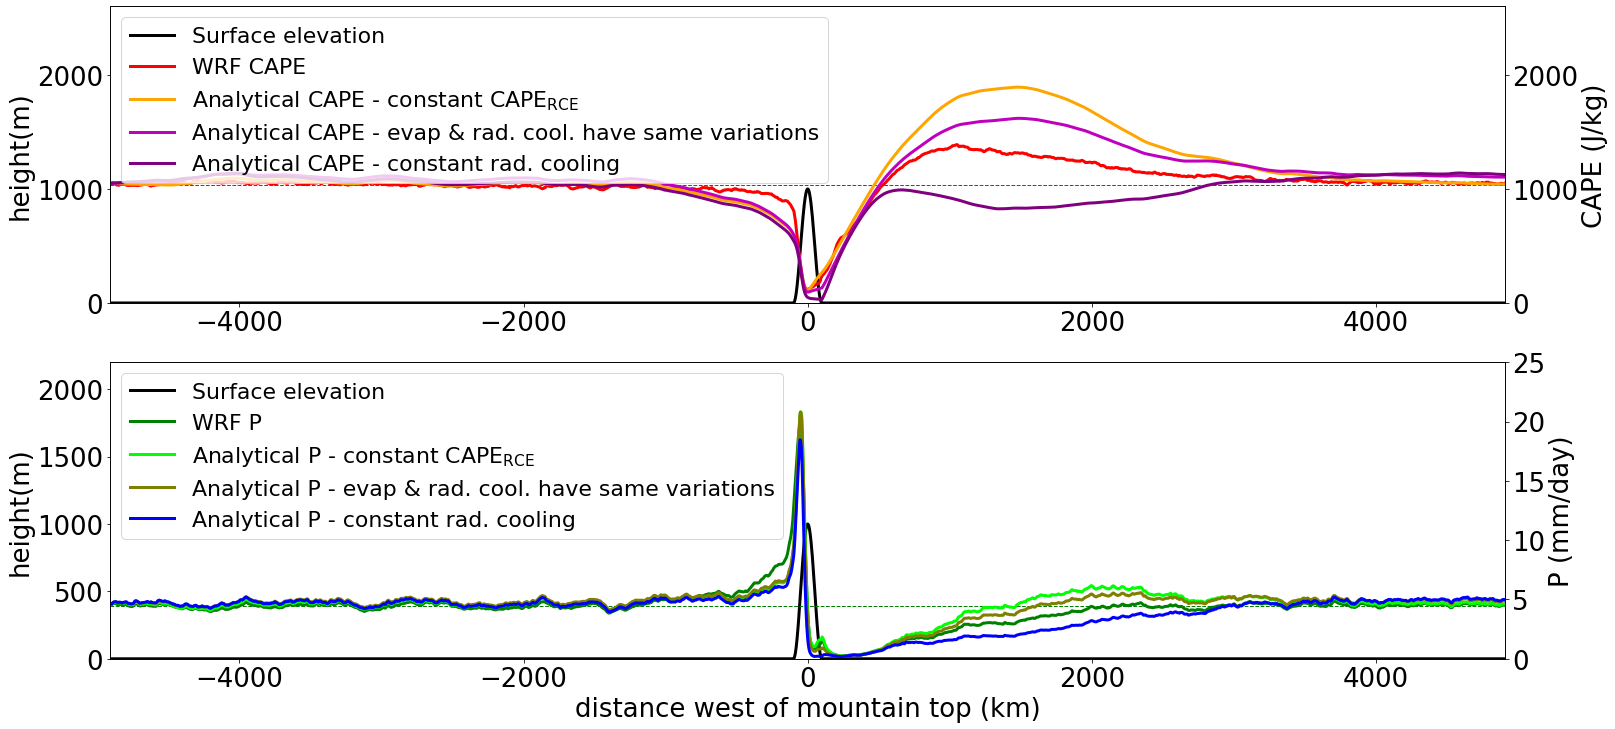

In [110]:
matplotlib.rcParams.update({'font.size': 26})
_,(axmt1,axmt2)=plt.subplots(2,1,figsize=(25,12))
axca=axmt1.twinx()
axpr=axmt2.twinx()

#PANEL 1 - CAPE

axmt1.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
axca.plot(hrdist,hrcape,label="WRF CAPE",color='r',linewidth=3)
axca.axhline(hrcape[2000:3000].mean(),color='r',linestyle='--',linewidth=1)

axca.plot(hrdist,hrcape_analytical_alpha1[::-1], label=r"Analytical CAPE - constant CAPE$_{\mathrm{RCE}}$"        ,color='orange',linewidth=3)
axca.plot(hrdist,hrcape_analytical_alphae[::-1], label=r"Analytical CAPE - evap & rad. cool. have same variations",color='m',linewidth=3)
axca.plot(hrdist,hrcape_analytical_alphaer[::-1],label=r"Analytical CAPE - constant rad. cooling"                ,color='purple',linewidth=3)

lines1,labels1 = axmt1.get_legend_handles_labels()
lines2,labels2 = axca.get_legend_handles_labels()
axca.legend(lines1 + lines2, labels1 + labels2,loc=2,fontsize=22)

axmt1.set_xlim(-4910,4910)
axmt1.set_ylim(0,2600)
axca.set_ylim( 0,2600)

axmt1.set_ylabel("height(m)")
axca.set_ylabel("CAPE (J/kg)")


#PANEL 2 - Precipitation

axmt2.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
axpr.plot(hrdist,hrpr,label="WRF P",color='g',linewidth=3)
axpr.axhline(hrpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)

axpr.plot(hrdist,hrpr_analytical_alpha1[::-1], label=r"Analytical P - constant CAPE$_{\mathrm{RCE}}$"        ,color='lime',linewidth=3)
axpr.plot(hrdist,hrpr_analytical_alphae[::-1], label=r"Analytical P - evap & rad. cool. have same variations",color='olive',linewidth=3)
axpr.plot(hrdist,hrpr_analytical_alphaer[::-1],label=r"Analytical P - constant rad. cooling"                ,color='b',linewidth=3)


lines1,labels1 = axmt2.get_legend_handles_labels()
lines2,labels2 = axpr.get_legend_handles_labels()
axpr.legend(lines1 + lines2, labels1 + labels2, loc=2,fontsize=22)

axmt2.set_xlim(-4910,4910)
axmt2.set_ylim(0,2200)
axpr.set_ylim(0,25)

axmt2.set_ylabel("height(m)")
axpr.set_ylabel('P (mm/day)')
axmt2.set_xlabel("distance west of mountain top (km)")

fig.tight_layout()

# Figure 9 - results with lower mountain

In [10]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
lmhgt = lmchannel.HGT.isel(south_north=0,Time=-1).persist()

In [125]:
factor = 8000/(2.26e6/86400)
lmtauc_intervals = np.zeros((15,len(hrchannel.west_east)))
for i,t in enumerate(range(200,800,40)):
    lmpr_interval=np.array(lmchannelprecip.isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    lmcape_interval=np.array(lmchannel_capecin[0].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())
    lmtauc_intervals[i]=lmcape_interval/lmpr_interval*factor

In [12]:

lmCAPERCE = 1000
L=450e3
lmtauc0=7e4

# f from simulation
x = 1000*(1635-hrhgt.west_east)*3 #+ 4902000
x = x[::-1] 
lmcape=lmchannel_capecin[0].isel(Time=slice(200,1200)).mean(['south_north','Time'])
lmpr = lmchannelprecip.isel(Time=slice(200,1200)).mean(['south_north','Time'])
lmtauc=lmcape/(2.26e6*lmpr/86400/8000)
lmfsim = np.array(lmtauc[::-1]/lmtauc.isel(west_east=slice(2000,3000)).mean())
print("baseline tau_c in lm simulation : %.1e s"%(lmtauc.isel(west_east=slice(2000,3000)).mean()))

baseline tau_c in lm simulation : 6.8e+04 s


In [120]:
lmevap = lmchannel.QFX.isel(Time=slice(200,1200)).mean(['south_north','Time'])

In [121]:
%%time
Ms = 4200
Mh = 1500
Mq = Ms-Mh
lmalpha_evap1 = np.maximum(0.,np.array((Ms*lmevap/lmevap[2000:3000].mean()-Mq)/Mh)[::-1])
lmalpha_evaponly = np.array(lmevap/lmevap.mean())[::-1]

CPU times: user 2.26 s, sys: 23.5 s, total: 25.7 s
Wall time: 43.9 s


In [122]:
lmcape_analytical_alpha1 = cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,1.)
lmpr_analytical_alpha1 = precip(lmcape_analytical_alpha1,lmtauc0*lmfsim)

lmcape_analytical_alphaer = cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,lmalpha_evap1)
lmpr_analytical_alphaer = precip(lmcape_analytical_alphaer,lmtauc0*lmfsim)

lmcape_analytical_alphae = cape_analytical_Lx(x,lmfsim,L,lmCAPERCE,lmalpha_evaponly)
lmpr_analytical_alphae = precip(lmcape_analytical_alphae,lmtauc0*lmfsim)


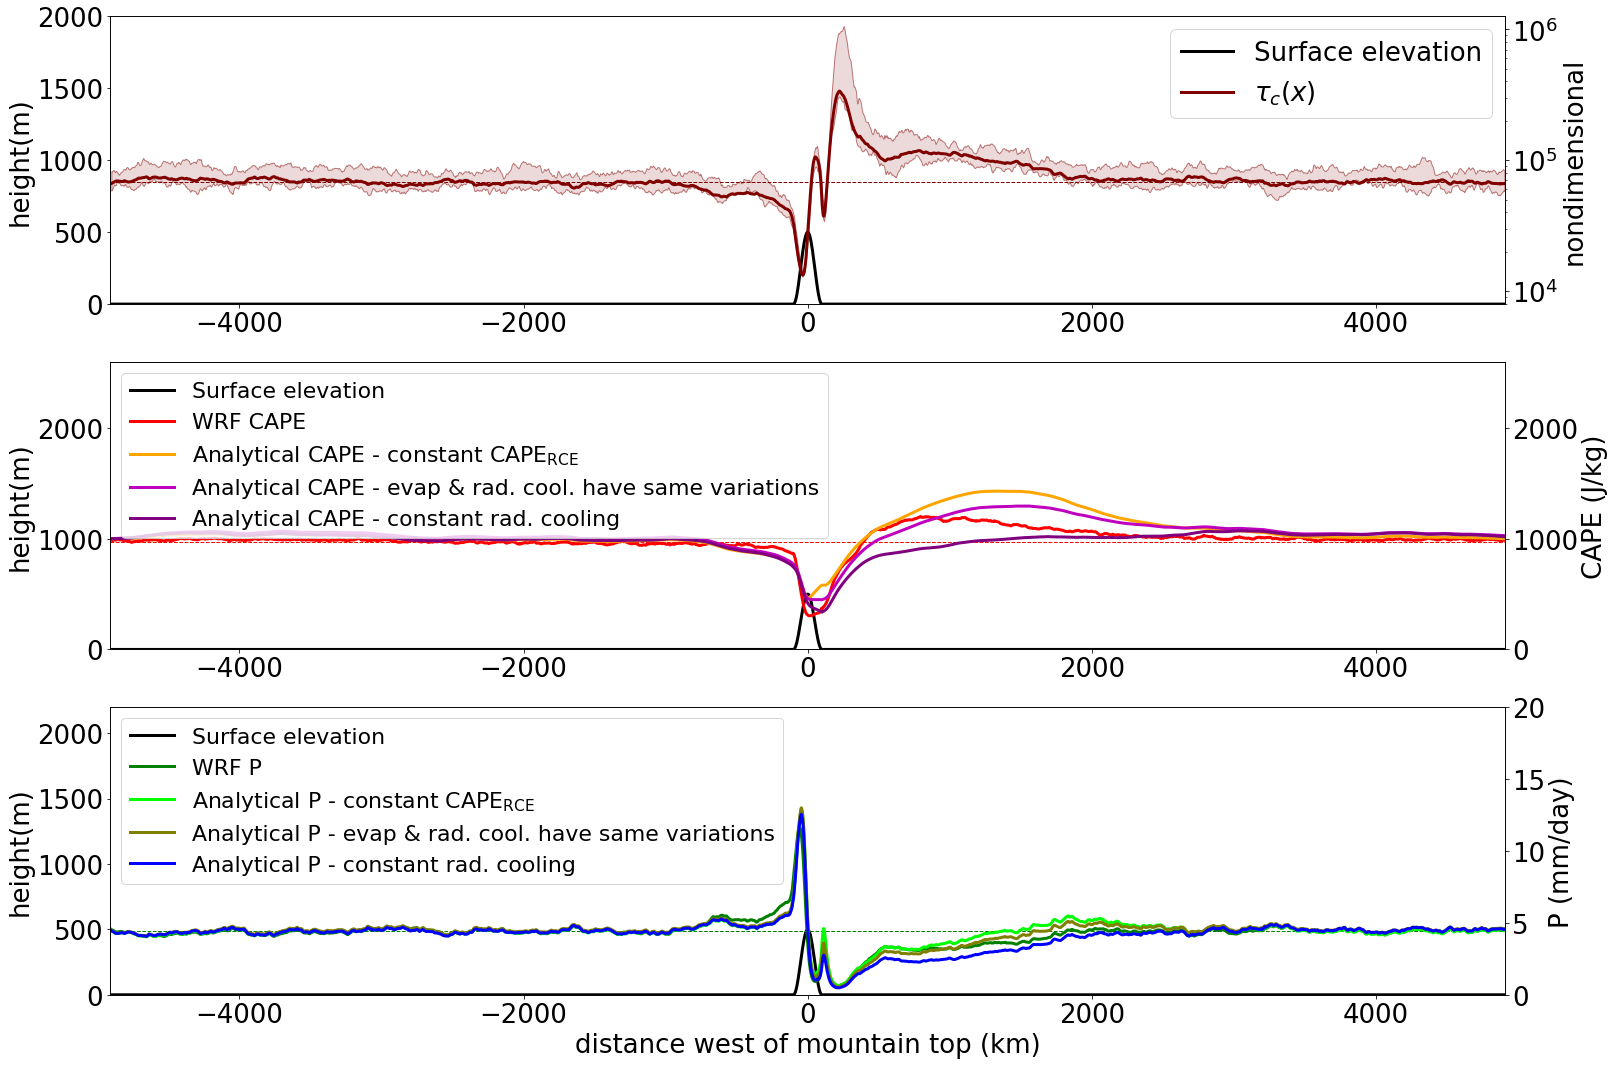

In [130]:
matplotlib.rcParams.update({'font.size': 26})
_,(axmt,axmt1,axmt2)=plt.subplots(3,1,figsize=(25,18))
axta=axmt.twinx()
axca=axmt1.twinx()
axpr=axmt2.twinx()

#PANEL 1 - Tau_c

axmt.plot(hrdist,lmhgt,color='k',label='Surface elevation',linewidth=3)
axta.plot(hrdist,lmtauc,label=r"$\tau_c(x)$",linewidth=3,color="maroon")
axta.axhline(lmtauc[2000:3000].mean(),linewidth=1,linestyle='--',color="maroon")

axta.fill_between(hrdist,np.percentile(lmtauc_intervals,25,axis=0),np.percentile(lmtauc_intervals,75,axis=0),facecolor=(0.5,0.,0,.15), edgecolor=(0.5,0.,0,.5))

linesmt, labelsmt = axmt.get_legend_handles_labels()
linesta, labelsta = axta.get_legend_handles_labels()
axta.legend(linesmt + linesta, labelsmt + labelsta, loc=0)

axmt.set_ylabel("height(m)")
axta.set_ylabel('nondimensional')
axmt.set_ylim(0,2000)
axmt.set_xlim(-4910,4910)
axta.set_ylim(10**3.9,10**6.1)
axta.set_yscale('log')

#PANEL 2 - CAPE

axmt1.plot(hrdist,lmhgt,color='k',label='Surface elevation',linewidth=3)
axca.plot(hrdist,lmcape,label="WRF CAPE",color='r',linewidth=3)
axca.axhline(lmcape[2000:3000].mean(),color='r',linestyle='--',linewidth=1)

axca.plot(hrdist,lmcape_analytical_alpha1[::-1], label=r"Analytical CAPE - constant CAPE$_{\mathrm{RCE}}$"        ,color='orange',linewidth=3)
axca.plot(hrdist,lmcape_analytical_alphae[::-1], label=r"Analytical CAPE - evap & rad. cool. have same variations",color='m',linewidth=3)
axca.plot(hrdist,lmcape_analytical_alphaer[::-1],label=r"Analytical CAPE - constant rad. cooling"                ,color='purple',linewidth=3)

lines1,labels1 = axmt1.get_legend_handles_labels()
lines2,labels2 = axca.get_legend_handles_labels()
axca.legend(lines1 + lines2, labels1 + labels2,loc=2,fontsize=22)

axmt1.set_xlim(-4910,4910)
axmt1.set_ylim(0,2600)
axca.set_ylim( 0,2600)

axmt1.set_ylabel("height(m)")
axca.set_ylabel("CAPE (J/kg)")


#PANEL 3 - Precipitation

axmt2.plot(hrdist,lmhgt,color='k',label='Surface elevation',linewidth=3)
axpr.plot(hrdist,lmpr,label="WRF P",color='g',linewidth=3)
axpr.axhline(lmpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)

axpr.plot(hrdist,lmpr_analytical_alpha1[::-1], label=r"Analytical P - constant CAPE$_{\mathrm{RCE}}$"        ,color='lime',linewidth=3)
axpr.plot(hrdist,lmpr_analytical_alphae[::-1], label=r"Analytical P - evap & rad. cool. have same variations",color='olive',linewidth=3)
axpr.plot(hrdist,lmpr_analytical_alphaer[::-1],label=r"Analytical P - constant rad. cooling"                ,color='b',linewidth=3)


lines1,labels1 = axmt2.get_legend_handles_labels()
lines2,labels2 = axpr.get_legend_handles_labels()
axpr.legend(lines1 + lines2, labels1 + labels2, loc=2,fontsize=22)

axmt2.set_xlim(-4910,4910)
axmt2.set_ylim(0,2200)
axpr.set_ylim(0,20)

axmt2.set_ylabel("height(m)")
axpr.set_ylabel('P (mm/day)')
axmt2.set_xlabel("distance west of mountain top (km)")

fig.tight_layout()

# Figure 10 - CIN & wrms profiles

In [194]:
hrcin=hrchannel_capecin[1].isel(Time=slice(200,801)).mean(['Time','south_north']).load()


In [195]:
%%time
hrcin_intervals   = np.zeros((15,len(hrchannel.west_east)))
for i,t in enumerate(range(200,800,40)):
    hrcin_intervals[i]=np.array(hrchannel_capecin[1].isel(Time=slice(t,t+40)).mean(['Time','south_north']).load())

CPU times: user 1.08 s, sys: 824 ms, total: 1.9 s
Wall time: 1.84 s


In [206]:
wrms=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.rms.days50-200.nc")
wrms=change_coords_pl(hrchannel_p,wrms)[1:-4]
wrms=wrms.where(wrms<5)

In [234]:
%%time 
w_s_rms=xr.ufuncs.sqrt((hrchannel.W.isel(Time=slice(200,801))**2).mean(['Time','south_north'])).persist()
w_s_rms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.rms.days50-200.nc')

CPU times: user 29.6 s, sys: 11min 40s, total: 12min 10s
Wall time: 6min 55s


In [235]:
print("done")

done


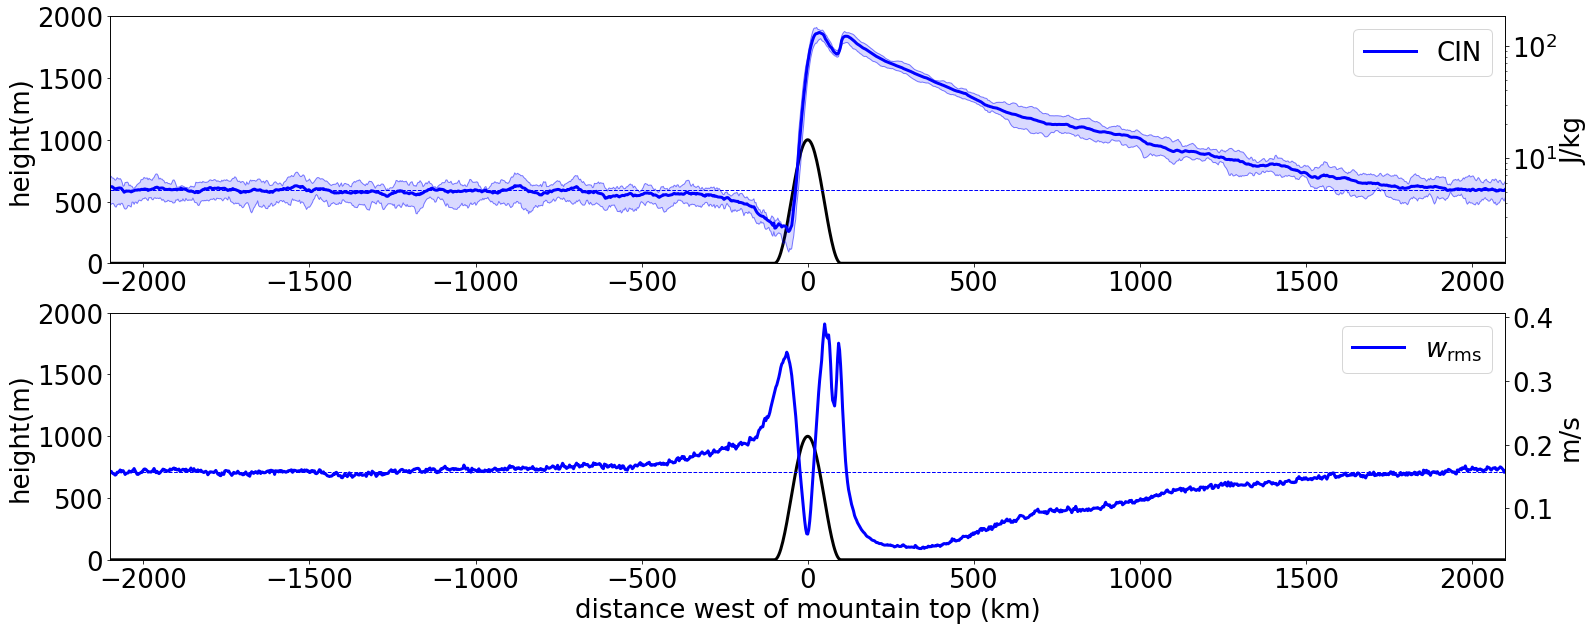

In [233]:
matplotlib.rcParams.update({'font.size': 26})

_,(axmt1,axmt2)=plt.subplots(2,1,figsize=(25,10))
axc=axmt1.twinx()
axw=axmt2.twinx()

#PANEL 1 - MOUNTAIN & CIN

axmt1.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
axc.plot(hrdist,hrcin,label="CIN",linewidth=3,color="b")
axc.axhline(hrcin[2000:3000].mean(),linewidth=1,linestyle='--',color="b")

axc.fill_between(hrdist,np.percentile(hrcin_intervals,25,axis=0),np.percentile(hrcin_intervals,75,axis=0),facecolor=(0,0,1,.15), edgecolor=(0,0,1,.5))

axc.legend()

axmt1.set_ylabel("height(m)")
axc.set_ylabel('J/kg')
axmt1.set_ylim(0,2000)
axmt1.set_xlim(-2100,2100)
#axc.set_ylim(10**(-2),10**2)
axc.set_yscale('log')

#PANEL 2 - MOUNTAIN & Wrms

axmt2.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
axw.plot(hrdist,wrms.sel(pressure=875),label=r"$w_\mathrm{rms}$",linewidth=3,color="b")
axw.axhline(wrms.sel(pressure=875)[2000:3000].mean(),linewidth=1,linestyle='--',color="b")

axw.legend()

axmt2.set_xlabel("distance west of mountain top (km)")
axmt2.set_ylabel("height(m)")
axw.set_ylabel('m/s')
axmt2.set_ylim(0,2000)
axmt2.set_xlim(-2100,2100)
#axc.set_ylim(10**(-2),10**2)

fig.tight_layout()

# Figure 11 - x-z cross section of temperature deviation from upstream

In [224]:
tmean_s = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc'),staggered=False)
tmean_p = interp_eta_to_pressure(hrchannel,tmean_s,staggered=0)


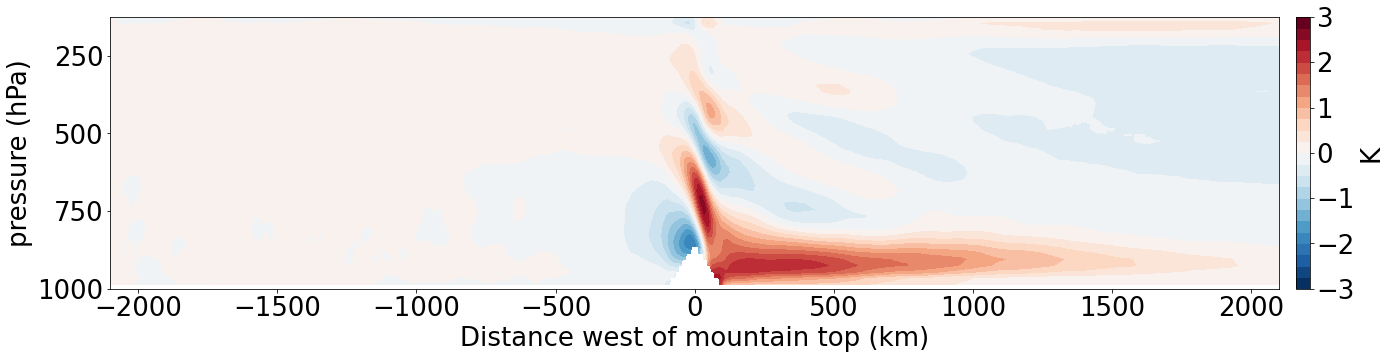

In [232]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
tlevs=np.arange(-3,3.01,0.25)
tticks=np.arange(-3,3.01,1)

(tmean_p-tmean_p[:,2000:3000].mean('distance_from_mtn')).plot.contourf(ax=ax,yincrease=False,levels=tlevs,cbar_kwargs={'ticks':tticks,'label':'K','pad':.012})

ax.set_xlabel("Distance west of mountain top (km)")
ax.set_ylabel("pressure (hPa)")
ax.set_xlim(-2100,2100)
ax.set_yticks([250,500,750,1000])



# Precip enhancement scaling

In [42]:
(hrpr[1635:1635+50].mean()-4)/4

<xarray.DataArray ()>
array(2.27070856)

In [43]:
hrtauc[1635:1635+50].mean()/hrtauc[2000:3000].mean()

<xarray.DataArray ()>
array(0.1953866)
Coordinates:
    projection          int64 1
    mcape_mcin_lcl_lfc  <U5 'mcape'

In [46]:
(lmpr[1635:1635+50].mean()-4)/4

<xarray.DataArray 'RAINNC' ()>
array(1.09484386)

In [47]:
(lmtauc[1635:1635+50].mean()/lmtauc[2000:3000].mean()).load()

<xarray.DataArray ()>
array(0.37942997)
Coordinates:
    mcape_mcin_lcl_lfc  <U5 'mcape'

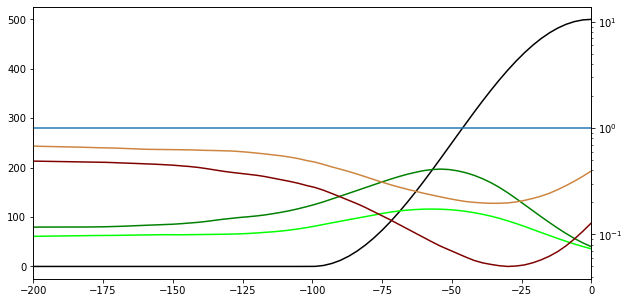

In [29]:
_,axmt=plt.subplots(1,1,figsize=(10,5))
axta=axmt.twinx()

#PANEL 1 - Tau_c

axmt.plot(hrdist,lmhgt,color='k',label='Surface elevation')
axmt.plot(hrdist,10*hrpr,color='g')
axmt.plot(hrdist,10*lmpr,color='lime')
axta.plot(hrdist,hrtauc/hrtauc[2000:3000].mean(),label=r"$\tau_c(x)$",color="maroon")
axta.plot(hrdist,lmtauc/lmtauc[2000:3000].mean(),label=r"$\tau_c(x)$",color="peru")
axta.axhline(1.)
axmt.set_xlim(-200,0)
axta.set_yscale('log')